July 18, 2021

Building off Simple ERCOT_01, which was the first model I built (and am quite proud of). The goals for this version is three-fold:
- Practice using virtual enviroments
- Upload grid specifications via CSVs
- Create more realistic and complex assumptions

For the assumptions, here is the primary resource: https://pypsa.readthedocs.io/en/latest/examples/unit-commitment.html

Here are all of the components: https://pypsa.readthedocs.io/en/latest/components.html

PyPSA has a built in function for uploading via CSVs (I'd like to look under the hood). I can also import from pandas Dataframe: https://pypsa.readthedocs.io/en/latest/api_reference.html#pypsa.Network.import_components_from_dataframe  I think I prefer to update from pandas dataframes. 

Here is another great resource, especially for plotting but also for uploading data: https://www.pypsa.org/examples/scigrid-lopf-then-pf-plotly.html

In [1]:
import pypsa, numpy as np, matplotlib.pyplot as plt, pandas as pd

In [2]:
# These are the examples found in the link above. I just need to see the format. 
# Interesting to also see the different options. Clearly a "good" accurate model
# Would be very complex. 
buses = ['Berlin', 'Frankfurt', 'Munich', 'Hamburg']

df_0 = pd.DataFrame({"v_nom" : 380, "control" : 'PV'},
                    index=buses)
df_0        

,v_nom,control
Berlin,380,PV
Frankfurt,380,PV
Munich,380,PV
Hamburg,380,PV


In [3]:
df_1 = pd.DataFrame({"carrier" : "solar", "bus" : buses, "p_nom_extendable" : True},
                    index=[b+" PV" for b in buses])
df_1

# Notes on Carrier from Components Website: Energy carrier, such as AC, DC, heat, wind, PV or coal. 
# Buses have direct carriers and Generators indicate their primary energy carriers.
# The Carrier can track properties relevant for global constraints, such as CO2 emissions.

,carrier,bus,p_nom_extendable
Berlin PV,solar,Berlin,True
Frankfurt PV,solar,Frankfurt,True
Munich PV,solar,Munich,True
Hamburg PV,solar,Hamburg,True


In [4]:
# Upload and Visualize Loads
#  These are just random example loads
# 30 min granularity
load_df = pd.read_csv("load_01.csv")
load_df['name'] = pd.to_datetime(load_df['name'])
load_df.set_index("name", inplace = True)
load_df.head()

,North,South,West,Houston
name,,,,
2021-07-18 00:00:00,7500,5625,1725,11625
2021-07-18 00:30:00,7500,5625,1725,11625
2021-07-18 01:00:00,7500,5625,1725,11625
2021-07-18 01:30:00,9000,8250,2370,13350
2021-07-18 02:00:00,7500,5625,1725,11625


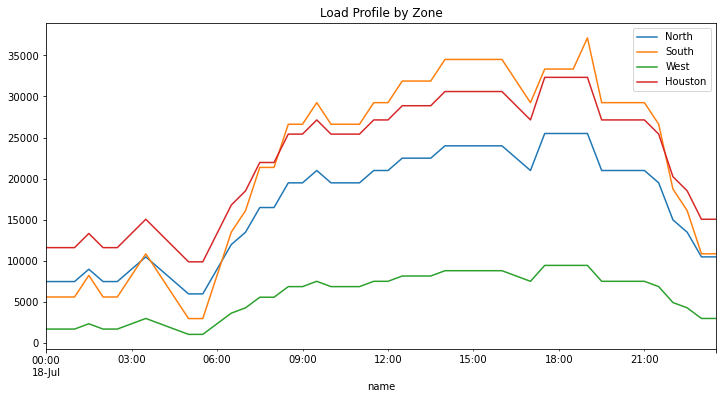

In [5]:
# LOAD PROFILE
zones = ['North', 'South', 'West', 'Houston']

for zone in zones:
    load_df["{}".format(zone)].plot(label = "{}".format(zone), figsize = (12,6))
plt.title("Load Profile by Zone")
plt.legend()
plt.show()

In [6]:
# RENEWABLE GEN PROFILE

# As with the load profiles, these are only examples
ren_gen_df = pd.read_csv("ren_gen_profiles_01.csv")
ren_gen_df['name'] = pd.to_datetime(ren_gen_df['name'])
ren_gen_df.set_index(ren_gen_df['name'], inplace = True)
del ren_gen_df['name']
ren_gen_df.head()

,N_solar,S_solar,W_solar,H_solar,N_wind,S_wind,W_wind,H_wind
name,,,,,,,,
2021-07-18 00:00:00,0.0,0.0,0.0,0.0,0.6,0.6,0.6,0.6
2021-07-18 00:30:00,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5
2021-07-18 01:00:00,0.0,0.0,0.0,0.0,0.6,0.6,0.6,0.6
2021-07-18 01:30:00,0.0,0.0,0.0,0.0,0.6,0.6,0.6,0.6
2021-07-18 02:00:00,0.0,0.0,0.0,0.0,0.7,0.7,0.7,0.7


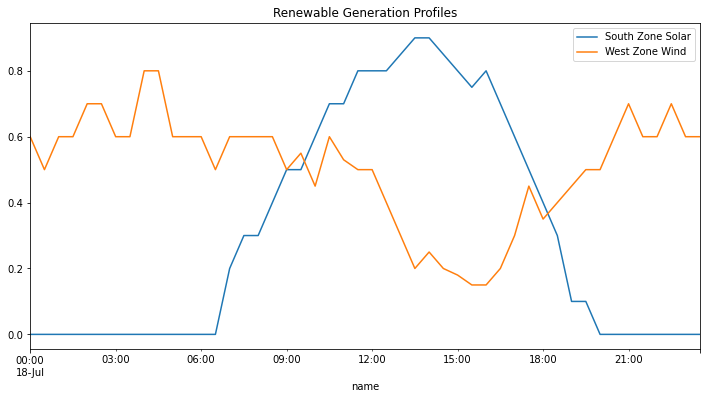

In [7]:
ren_gen_df['S_solar'].plot(label = "South Zone Solar", figsize = (12,6))
ren_gen_df['W_wind'].plot(label = "West Zone Wind", figsize = (12,6))
plt.legend()
plt.title("Renewable Generation Profiles")
plt.show()

In [8]:
# GENERATOR DATAFRAME
gen_df = pd.read_csv("generators_02.csv", 
                    index_col = 0)
gen_df.head()

,bus,p_nom,marginal_cost,min_down_time
N_solar,North,0,3,0
S_solar,South,7000,3,0
W_solar,West,0,3,0
H_solar,Houston,0,3,0
N_wind,North,0,4,0


In [9]:
# DEFINE TRANSMISSION
# We will be assuming bidirectional Transmission
transmission = {"West" : {"North" : 2000,
                         "South" : 5000},
               "North" : {"Houston" : 1500},
               "South" : {"North" : 2000,
                          "Houston" : 3500}                       
              }


In [10]:
# MODEL ASSEMBLY
ercot_model = pypsa.Network()

ercot_model.set_snapshots(load_df.index) # I tried to set snapshots within Network, did not work

for zone in zones:
    print("Assembling {} zone Bus, Load, and Transmission data".format(zone))
    # ADD BUSES
    ercot_model.add("Bus", zone)
    
    # ADD LOAD
    ercot_model.add("Load",
               "{} load".format(zone), 
               bus = zone,
               p_set = load_df[zone])
    
    # ADD TRANSMISSION
    if zone not in transmission:
        continue
    for other_zone in zones:
        if other_zone not in transmission[zone]:
            continue
        ercot_model.add("Link",
                   "{} - {} link".format(zone, other_zone),
                   bus0 = zone,
                   bus1 = other_zone,
                   p_nom = transmission[zone][other_zone], 
                   p_min_pu = -1) # makes bidirectional
    
print("Adding Generation")
ercot_model.import_components_from_dataframe(gen_df, "Generator")

print("Adding Production profiles for renewables")
# THIS IS KEY, Had to go into the google groups:
# need to import time varying aspects as import_series_from_dataframe
# https://groups.google.com/g/pypsa/c/TyrHiU4gGIo/m/0wyjCVw4AwAJ

# Also of interest is time varying costs, (esp. for Gas), but that's something to come b
# back to. 
ercot_model.import_series_from_dataframe(ren_gen_df, 
                                        "Generator", 
                                        "p_max_pu")
print("Done!")

Assembling North zone Bus, Load, and Transmission data
Assembling South zone Bus, Load, and Transmission data
Assembling West zone Bus, Load, and Transmission data
Assembling Houston zone Bus, Load, and Transmission data
Adding Generation
Adding Production profiles for renewables
Done!


/home/colburn/Programs/anaconda3/envs/ERCOT_Models/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))


In [11]:
ercot_model.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
/home/colburn/Programs/anaconda3/envs/ERCOT_Models/lib/python3.8/site-packages/pypsa/opf.py:86: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  for gen in extendable_gens_i | fixed_committable_gens_i
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 57718161.0
  Upper bound: 57718161.0
  Number of objectives: 1
  Number of constraints: 673
  Number of variables: 1969
  Number of nonzeros: 2689
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03397488594055176
# ----------------------------------------------------------
#   Solution Information
# -------------------

/home/colburn/Programs/anaconda3/envs/ERCOT_Models/lib/python3.8/site-packages/pypsa/opf.py:1296: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat({c.name:


(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [12]:
gen = ercot_model.generators_t.p


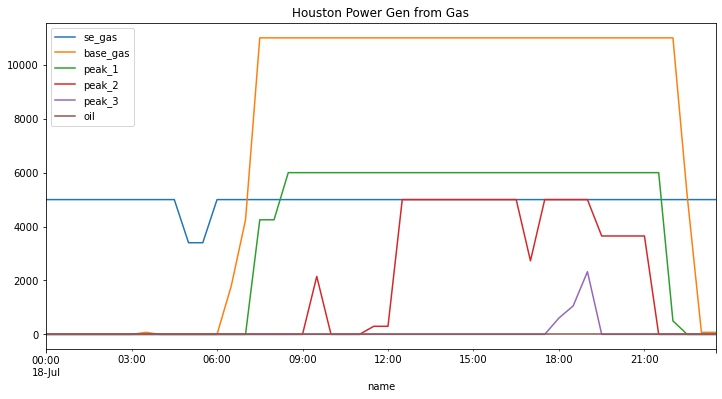

In [13]:
techs = ['solar', 'wind', 'nuke', 'se_gas', 'base_gas', 'peak_1', 'peak_2', 'peak_3', 'oil']
gases = ['se_gas', 'base_gas', 'peak_1', 'peak_2', 'peak_3', 'oil']

for gas in gases:
    gen['H_{}'.format(gas)].plot(label = "{}".format(gas), figsize = (12,6))
plt.title("Houston Power Gen from Gas")
plt.legend()
plt.show()

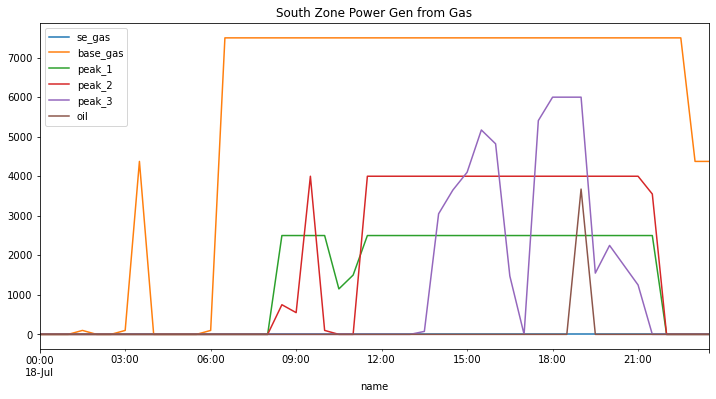

In [15]:
for gas in gases:
    gen['S_{}'.format(gas)].plot(label = "{}".format(gas), figsize = (12,6))
plt.title("South Zone Power Gen from Gas")
plt.legend()
plt.show()

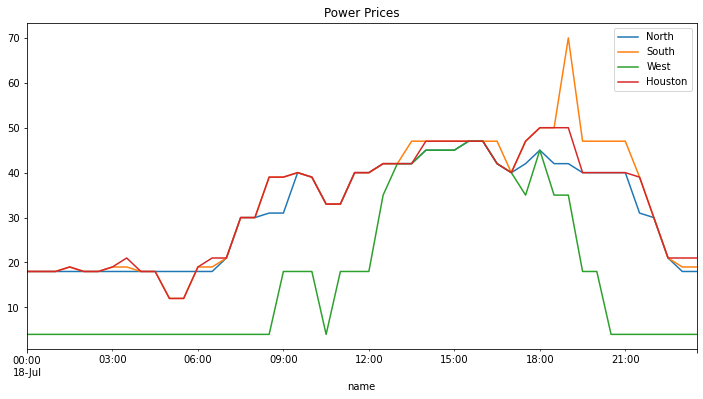

In [14]:
price = ercot_model.buses_t.marginal_price

for zone in zones:
    price['{}'.format(zone)].plot(label = "{}".format(zone), figsize = (12,6))
plt.title("Power Prices")
plt.legend()
plt.show() 